# DeepLearning Assignment 1 实验报告
# SA22221042 汪泱泱

## 一、实验过程


In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import random

from torch import nn
from sklearn import datasets
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


在$[0,4\pi)$随机生成样本x，根据$y=\sin(x)+e^{-x}$计算对应的y值

In [30]:
num_samples = 10000
x = np.random.uniform(0, 4*np.pi, num_samples)
np.random.shuffle(x)
x = x.reshape(-1, 1)
x = torch.tensor(x, dtype=torch.float32)
y = torch.sin(x) + torch.exp(-x)

按照7:1:2划分训练集、验证集、测试集

In [31]:
train_rate = 0.7
validation_rate = 0.1
test_rate = 0.2
train_samples = round(num_samples * train_rate)
validation_samples = round(num_samples * (train_rate + validation_rate))
train_x = x[:train_samples]
train_y = y[:train_samples]
validation_x = x[train_samples:validation_samples]
validation_y = y[train_samples:validation_samples]
test_x = x[validation_samples:]
test_y = y[validation_samples:]

 将划分好的训练集、验证集、测试集从Tensor格式转化成DataLoader格式

In [32]:
batch_size=256

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

dataset = TensorDataset(validation_x, validation_y)
validation_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

神经网络模型的类，继承nn.Module。

由于仅需要拟合一维函数，所以神经网络仅由全连接层和激活函数两种网络组成。

由于后面要分析网络深度、网络宽度、激活函数对模型性能的影响，所以先不将网络深度、网络宽度、激活函数写死，而是通过初始化函数的参数决定。


In [33]:
class Model(nn.Module):
    activation_dict = {
        'Logistic': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'ReLU': nn.ReLU(),
        'ELU': nn.ELU(),
        'Softplus': nn.Softplus()
    }
    def __init__(self, hidden_layer_num, layer_size, activation):
        super().__init__()
        assert hidden_layer_num>0
        self.activation = self.activation_dict[activation]
        self.fc_list = nn.ModuleList()
        self.fc_list.append(nn.Linear(1, layer_size))
        for i in range(hidden_layer_num-1):
            self.fc_list.append(nn.Linear(layer_size, layer_size))
        self.fc_list.append(nn.Linear(layer_size, 1))

    def forward(self, x):
        for i in range(len(self.fc_list)):
            x = self.fc_list[i](x)
            if i != len(self.fc_list)-1:
                x = self.activation(x)
        return x


先选择ReLU激活函数、隐藏层层数5、每层100个神经元实例化模型。

使用Adam优化器，学习率先设置为1e-3

将模型放在gpu上，以加速模型训练

In [34]:
activation = 'ReLU'
hidden_layer_num = 5
layer_size = 100
model = Model(hidden_layer_num, layer_size, activation)
n_gpu = torch.cuda.device_count()
device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
model = model.to(device)
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

对模型进行训练，根据要求选择MSE作为损失函数，每隔10个epoch记录训练集和验证集上的损失，以备作图

In [35]:
Loss = nn.MSELoss()
epochs = 100
train_losses = []
validation_losses = []
for epoch in range(epochs):
    for batch_id, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = Loss(y, output)
        loss.backward()
        optimizer.step()
    if (epoch+1)%10 == 0:
        print('[Epoch {}/{}] Train Loss = {:.4f}, Validation Loss = {:.4f}'
        .format(epoch + 1, epochs, Loss(train_y, model(train_x)), Loss(validation_y, model(validation_x))))
        train_losses.append(float(Loss(train_y, model(train_x)).detach().numpy()))
        validation_losses.append(float(Loss(validation_y, model(validation_x))))

[Epoch 10/100] Train Loss = 0.0916, Validation Loss = 0.0968
[Epoch 20/100] Train Loss = 0.0170, Validation Loss = 0.0185
[Epoch 30/100] Train Loss = 0.0013, Validation Loss = 0.0014
[Epoch 40/100] Train Loss = 0.0030, Validation Loss = 0.0031
[Epoch 50/100] Train Loss = 0.0001, Validation Loss = 0.0001
[Epoch 60/100] Train Loss = 0.0001, Validation Loss = 0.0001
[Epoch 70/100] Train Loss = 0.0002, Validation Loss = 0.0002
[Epoch 80/100] Train Loss = 0.0006, Validation Loss = 0.0006
[Epoch 90/100] Train Loss = 0.0005, Validation Loss = 0.0005
[Epoch 100/100] Train Loss = 0.0001, Validation Loss = 0.0001


作出训练误差和验证误差关于ehoch的折线图

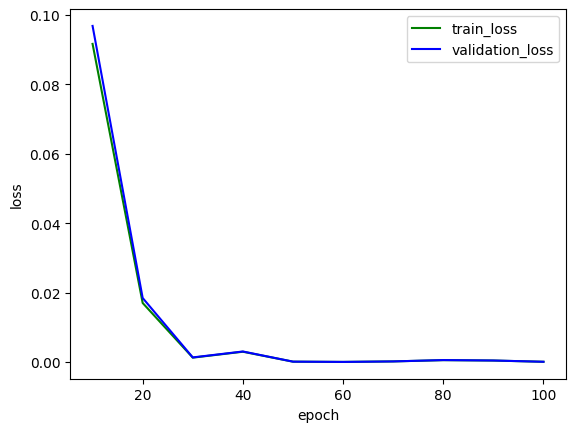

In [36]:
epoch_x = np.linspace(10, epochs, epochs//10).tolist()
plt.plot(epoch_x, train_losses, label="train_loss",color='g')
plt.plot(epoch_x, validation_losses, label="validation_loss",color='b')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

作出训练得到的模型在验证集上产生(x,y)的散点图（由于验证集样本较多，选取了其中300个点）

为了体现效果，我们将$y=\sin(x)+e^{-x}$在$[0,4\pi)$的图像绘制在同一张图上

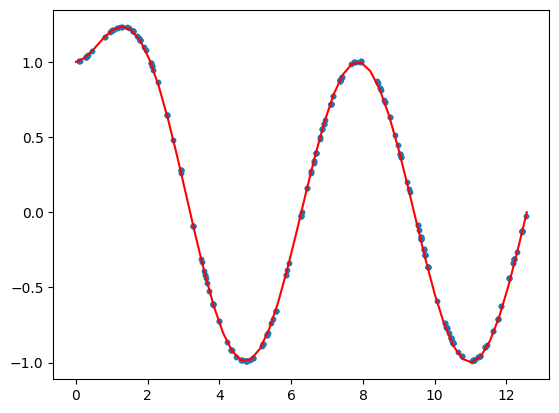

In [46]:
t = validation_x.clone()
random.shuffle(t)
x = t[:300]
y = model(x).detach().numpy()
plt.scatter(x, y, s=10)

x = np.linspace(0, 4*np.pi)
plt.plot(x, np.sin(x)+np.exp(-x),'r')

可以发现，散点大都离目标函数图像较近，所以训练效果还是不错的。

## 二、探究网络超参数（深度、宽度、激活函数）和学习率对模型性能的影响

#### 1、网络深度对模型的影响

In [ ]:
activation = 'ReLU'
layer_size = 100
validation_losses_dict = {}
for hidden_layer_num in range(1, 9):
    validation_losses_dict[hidden_layer_num] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs = 100
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            validation_losses_dict[hidden_layer_num].append(float(Loss(validation_y, model(validation_x))))

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for hidden_layer_num in range(1, 9):
    plt.plot(epoch_x, validation_losses_dict[hidden_layer_num], label='hidden layer = '+str(hidden_layer_num))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 2、学习率对模型的影响

In [ ]:
activation = 'ReLU'
layer_size = 100
hidden_layer_num = 5
validation_losses_dict = {}
learning_rate_list = [1e-2, 3e-2, 1e-3, 3e-4, 1e-4, 1e-5]
for learning_rate in learning_rate_list:
    validation_losses_dict[hidden_layer_num] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs = 100
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            validation_losses_dict[learning_rate].append(float(Loss(validation_y, model(validation_x))))

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for learning_rate in learning_rate_list:
    plt.plot(epoch_x, learning_rate_list[learning_rate], label='lr = '+str(hidden_layer_num))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()